In [1]:
### IMPORTS ###
import glob, os, datacube, xarray, bokeh, time, math
import stlabutils;   # import stlab
import numpy as np
### bokeh imports:
from bokeh.layouts import column, row
from bokeh.models import ColumnDataSource, Slider, CustomJS, LinearColorMapper
from bokeh.plotting import figure, output_file, show
from bokeh.io import push_notebook
import matplotlib as mpl
from mpl_toolkits.axes_grid1 import make_axes_locatable

### plottings, tables and figures ###
import matplotlib.pyplot  as plt
from matplotlib.gridspec import GridSpec
import matplotlib.colors as colors
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.ticker import FormatStrFormatter
from tabulate import tabulate
import ipywidgets as widgets

### data-explorer ####
import dexplore as dx     #don't forget to pip install: numpy, xarray, matplotlib, bokeh
                          #or if not working: go to terminal, cd git, pip install --upgrade xarray==2022.3.0 to downgrade xarray!
from IPython.display import Video, Image, HTML, display

#standard variables:
from scipy.constants import hbar, h, e, pi

########################################### settings and document files ################################################
File_path = "/home/jovyan/steelelab/measurement_data/Triton/Jasper/HBAR_transmon_flipchip/"
########################################################################################################################

### FUNCTIONS ###
#measurement time calculator:
def Meas_time(IFBW = 1, N_loop = 1, N_points = 1):
    tot_time = (N_loop*N_points)/IFBW
    print('Total measurement time is: '+str(tot_time)+' seconds') 
    print('Total measurement time in hours is: '+str(tot_time/3600)+' h') 
    return (N_loop*N_points)/IFBW

def TwoTone_Meas_time(pstart = 1, pstop = 1.5, step_fac = 1, R_pnt = 1, R_IFBW = 1, Q_pnt = 1, Q_IFBW = 1, ave=1):
    N_loop = p_stp = int((pstop-pstart)*step_fac) + 1
    R_time = (N_loop*R_pnt)/R_IFBW;     Q_time = ave*(N_loop*Q_pnt)/Q_IFBW
    t_tot = R_time + Q_time;            tot_hours = t_tot/3600
    print('Total measurement time in seconds is: '+str(t_tot)+' s') 
    print('Total measurement time in hours is: '+str(np.round(tot_hours,2))+' h') 
    
def quick_plot_data(file_name, style='lcm'):   #lc: linecut, cm: colormap, lcm: linecut + colormap
    if style=='lc':
        dx.interactive_linecut(dx.load_dat_meta_txt(File_path+file_name+'/'+file_name+'.dat'))
    elif style=='cm':
        dx.interactive_colormap(dx.load_dat_meta_txt(File_path+file_name+'/'+file_name+'.dat'))
    elif style=='lcm':
        dx.interactive_linecut_and_colormap(dx.load_dat_meta_txt(File_path+file_name+'/'+file_name+'.dat'))
        
def Fit_check(file_name, col=0):
    #read files:
    file_pre = File_path+file_name+'/'+file_name+'.dat'
    file = stlabutils.readdata.readdat(file_pre,delim=',')
    
    #extract data:
    Freq = file[col]['Frequency (Hz)'].values;    S21Real = file[col][' S21re ()'].values
    S21Imag = file[col][' S21im ()'].values;      S21 = S21Real + 1j*S21Imag
    
    #fit and calc:
    params = stlabutils.S11fit(Freq,S21,ftype='-A',fitbackground=True,trimwidth=2.,doplots=True,margin = None, oldpars=None, refitback = True, reusefitpars = False, fitwidth = None)
    x0 = params[1];             z0 = params[2];                 params = params[0]
    f0=(params['f0'].value);    Qext=(params['Qext'].value);    Qint=(params['Qint'].value)
    Qtot=(1/((1/(params['Qext'].value))+(1/(params['Qint'].value))))
    Kaptot=(params['f0'].value/(1/((1/(params['Qext'].value))+(1/(params['Qint'].value)))))
    Kapext=(params['f0'].value/(params['Qext'].value));          Kapint=(params['f0'].value/(params['Qint'].value))
    return f0,Qext,Qint,Qtot,Kaptot,Kapext,Kapint

def load_data(file_name, column=6, rows = 2001):
    dat_file = File_path+file_name+'/'+file_name+'.dat'
    data = np.loadtxt(dat_file,delimiter=',')
    data = np.reshape(data,[data.shape[0]//rows,rows, column])
#     print(data.shape)
    return data

def File_names(need_file):
    dat_files = sorted([s.split("/")[-1] for s in glob.glob(need_file+"/*")])
    for f in dat_files:
        print(f)
    return dat_files

def quadrature_plot(data_set):
    fig = plt.figure()
    sub1 = fig.add_subplot(221);              sub1.set_title('Magnitude')
    sub1.set_xlabel("Frequency [Hz]");        sub1.set_ylabel("S21dB [dB]")
    sub1.plot(data_set[0,:,0],data_set[0,:,3])

    sub2 = fig.add_subplot(222);              sub2.set_title('Phase')
    sub2.set_xlabel("Frequency [Hz]");        sub2.set_ylabel("Phase [rad]")
    sub2.plot(data_set[0,:,0],data_set[0,:,4])

    sub3 = fig.add_subplot(223) # statt plt.subplot(2, 2, 1)
    sub3.set_title('Real');                   sub3.set_xlabel("Frequency [Hz]")
    sub3.set_ylabel("Re(S21)");               sub3.plot(data_set[0,:,0],data_set[0,:,1])

    sub4 = fig.add_subplot(224);              sub4.set_title('Imaginary')
    sub4.set_xlabel("Frequency [Hz]");        sub4.set_ylabel("Im(21)")
    sub4.plot(data_set[0,:,0],data_set[0,:,2])
    
    plt.tight_layout(); plt.show()
    
def single_plot_S21MAG(data_set, Res=0):
    fig, ax = plt.subplots(figsize=(16,6));    ax.plot((data_set[0,:,0])/1e9,data_set[0,:,3],label='Data')
    ax.set_xlabel('Freq. [GHz]');              ax.set_ylabel('S21dB [dBm]')
    color_set = ['k','r','g','m','c','y','b']; txt = 'supected Resonances: '
    if Res !=0:
        for l, x in enumerate(Res):
            indx1 = min(range(len(data_set[0,:,0])), key=lambda i: abs(data_set[0,:,0][i]-Res[l]*1e9))
            S21_pnt = data_set[0,:,3][indx1]

            circ = plt.Circle((Res[l], S21_pnt), 0.1, color=color_set[l], fill=False, label='Res'+str(l+1))
            ax.add_patch(circ)
            txt = txt + str(Res[l]) +', '
        ax.legend();        ax.set_title(txt+' GHz') 
#-------------------------------------------------------------------------------------------------------------------
#measurement folder path
Path = File_path

#If needed, double check all file names in measurement folder:
dat_files = sorted([s.split("/")[-1] for s in glob.glob(Path+"*")])
for f in dat_files:
    fake=[]
    #print(f)
#-------------------------------------------------------------------------------------------------------------------    
def HighLow_power(file_name, H_pow = 0, L_pow = 0):
    #load data:
    file = stlabutils.readdata.readdat(File_path+file_name+'/'+file_name+'.dat',delim=',')
        
    #making a normal/usable power list:
    Pow1 = file[0][' Power (dBm)'].values;   Pow2 = file[-1][' Power (dBm)'].values
    Pow_span = abs(Pow1[0])+abs(Pow2[0]);    Pow_step = np.round(Pow_span/len(file),2)   
    Pow_list = np.arange(Pow1[0],Pow2[0]+Pow_step,Pow_step)
    
    #get index of high and low power
    idx_L = int(np.argmin(np.abs(np.array(Pow_list)-L_pow)));    idx_H = int(np.argmin(np.abs(np.array(Pow_list)-H_pow)))
    Read_list = [idx_H, idx_L]  
    
    #make lists:
    f_0=[]; Qe=[]; Qi=[]; Qt=[]; Ke=[]; Ki=[]; Kt=[];
    
    for i in Read_list:
        #extract data:
        Freq = file[i]['Frequency (Hz)'].values;        S21Real = file[i][' S21re ()'].values
        S21Imag = file[i][' S21im ()'].values;          Pow = file[i][' Power (dBm)'].values
        S21 = S21Real + 1j*S21Imag
    
        #fit and calc:
        params = stlabutils.S11fit(Freq,S21,ftype='-A',fitbackground=True,trimwidth=2.,doplots=False,margin = None, oldpars=None, refitback = True, reusefitpars = False, fitwidth = None)
        x0 = params[1];   z0 = params[2];    params = params[0]
        f0=(params['f0'].value);        Qext=(params['Qext'].value);        Qint=(params['Qint'].value)
        Qtot=(1/((1/(params['Qext'].value))+(1/(params['Qint'].value))))
        Kaptot=(params['f0'].value/(1/((1/(params['Qext'].value))+(1/(params['Qint'].value)))))
        Kapext=(params['f0'].value/(params['Qext'].value));        Kapint=(params['f0'].value/(params['Qint'].value))
        
        f_0.append(f0); Qe.append(Qext); Qi.append(Qint); Qt.append(Qtot); Ke.append(Kapext); Ki.append(Kapint); Kt.append(Kaptot);
        print('f_0 \t: ',np.round(f0/1e9,4),'GHz\n','Q_ext \t: ',Qext,'[-]\n','Q_int \t: ',Qint,'[-]\n','Q_tot \t: ',Qtot,'[-]\n','\u03BA_tot \t: ',Kaptot/1e6,'MHz\n','\u03BA_ext \t: ',Kapext/1e6,'MHz\n','\u03BA_int \t: ',Kapint/1e6,'MHz')
    print('----------------------------------------------------------------')
    print(tabulate([['High Power',H_pow,np.round(f_0[0]/1e9,5),np.round(Qi[0],1),np.round(Qe[0],1),np.round(Qt[0],1),np.round(Ki[0]/1e6,3),np.round(Ke[0]/1e6,3),np.round(Kt[0]/1e6,3)], 
                ['Low Power',L_pow,np.round(f_0[1]/1e9,5),np.round(Qi[1],1),np.round(Qe[1],1),np.round(Qt[1],1),np.round(Ki[1]/1e6,3),np.round(Ke[1]/1e6,3),np.round(Kt[1]/1e6,3)]], 
               headers=['','Probe [dB]','f_res[GHz]' ,'Q_int[-]','Q_ext[-]', 'Q_tot[-]', '\u03BA_int[MHz]', '\u03BA_ext[MHz]', '\u03BA_tot[MHz]']))
#-------------------------------------------------------------------------------------------------------------------    
# Below copied from Sercan's thesis + made some adjustments

def make_plots(file_name):
    dat_file = File_path+file_name+'/'+file_name+'.dat'
    data = dx.load_dat_meta_txt(dat_file); d = list(data.dims)
    if data.dims[list(data.coords)[1]] == 1: 
        dx.interactive_linecut(data)
    else:
        dx.interactive_linecut_and_colormap(data.transpose(d[1], d[0], d[2]))

def LoadDat_SingleTone(dat, meas_type = 'R'): 
    S_dat = stlabutils.readdata.readdat(dat);    S_nparr = np.zeros([np.shape(S_dat)[0],np.shape(S_dat)[1]], dtype=complex)
    S_g = np.zeros([np.shape(S_dat)[0],np.shape(S_dat)[1]]);    S_probe_power = np.zeros([np.shape(S_dat)[0]])
 
    for i in range(np.shape(S_dat)[0]): 
        idx = i 
        myblock = S_dat[idx]
        if (meas_type == 'B' or meas_type == 'B1'):
            rfpow = myblock['B1 Power (dBm)'][0]
            S11re = myblock['CH1_S21_S1re ()']
            S11im = myblock['CH1_S21_S1im ()']
            S11 = S11re + 1j * S11im
            if i == 0:
                freqs = myblock['Frequency (Hz)']
                f_arr = np.array(freqs)
        if meas_type == 'B2':
            rfpow = myblock['B2 Power (dBm)'][0]
            S11re = myblock['CH1_S21_S1re ()']
            S11im = myblock['CH1_S21_S1im ()']
            S11 = S11re + 1j * S11im
            if i == 0:
                freqs = myblock['Frequency (Hz)']
                f_arr = np.array(freqs)
        if meas_type == 'R':
            rfpow = myblock['Power (dBm)'][0]
            S11re = myblock['S21re ()']
            S11im = myblock['S21im ()']
            S11 = S11re + 1j * S11im
            if i == 0:
                freqs = myblock['Frequency (Hz)']
                f_arr = np.array(freqs)
        elif meas_type == 'QR': 
            rfpow = myblock['Qubit Pulse Time (ns)'][0]
            S11re = myblock['Real']
            S11im = myblock['Imaginary']
            S11 = S11re + 1j * S11im
            if i == 0:
                freqs = myblock['Qubit Frequency (Hz)']
                f_arr = np.array(freqs)
        if meas_type == 'G':
            S_g[i,:] = myblock['Group Delay']
        elif meas_type == 'R':
            pass
        S_nparr[i,:] = S11
        S_probe_power[i] = rfpow
    return S_nparr, S_probe_power, f_arr, S_g

def LoadDat_TwoTone(dat, meas_type): 
    S_dat = stlabutils.readdata.readdat(dat);    S_nparr = np.zeros([np.shape(S_dat)[0],np.shape(S_dat)[1]], dtype=complex)
    S_drive_power = np.zeros([np.shape(S_dat)[0]])
    
    if meas_type == 'B':
        d = 'B1 Power (dBm)'
    elif meas_type == 'T':
        d = 'Drive Power (dBm)'
    elif meas_type == 'U':
        d = 'B1 Power (dBm)'
    elif meas_type == 'L':
        d = 'B1 Power (dBm)'
    elif meas_type == 'Bf':
        d1 = 'B1 Frequency (Hz)'
        d2 = 'B2 Frequency (Hz)'
    elif meas_type == 'C':
        d = 'Current (mA)'
    
    for i in range(np.shape(S_dat)[0]): 
        idx = i 
        myblock = S_dat[idx]
        if (meas_type == 'U' or meas_type == 'L'):
            parr = np.array(myblock[d])
            pind = np.logical_not(np.isnan(parr))
            qpow = (parr[pind])[0]
        elif meas_type == 'Bf':
            qpow = (myblock[d1][0]+myblock[d2][0])/2
        else:
            qpow = myblock[d][0]
        S11re = myblock['CH2_S21_S1re ()']
        S11im = myblock['CH2_S21_S1im ()']
        S11 = S11re + 1j * S11im
        if i == 0:
            freqs = myblock['Frequency (Hz)']
            f_arr = np.array(freqs)
        S_nparr[i,:] = S11;        S_drive_power[i] = qpow
    return S_nparr, S_drive_power, f_arr

### !!! FUNCTION BELOW IS NOW ONLY SET FOR FREQ VS S21_DB !!!!###
"""
- Measurement:
    - set 1 probe power, measure multiple times the RO resonator (hence all the Reso folders)
    - set x times different drive powers and measure the Two Tone
    - now you have 2 folders corresponding to 1 set probe power
    - this is run multiple times (usually 24 times, every 2dB)
- function:
    - takes in 2 list (names of all RO folders and names of corresponding drive power sweeps)
    - list of RO:
        - each folder gets averaged
        - all averages are put together
    - list of Drive (TT):
        - each folder will be called upon when corresponding RO folder is shown in line cut
    - layout:
        - top-left: color map of all averaged RO power sweep data
            - controlled by left slider
        - top-right: line cut of this
            - controlled by left slider
        - bottom-left: color map of correspoding drive power sweep of two tone peak
            - controlled by left slider
        - bottom-right: line cut of two tone drive power sweep color plot
            - controlled by right slider
"""
def Probe_Drive_powerCheck(Res_List, TT_List, column_nr=9, row_nr=201, TTcolumn_nr=9, TTrow_nr=201):
    TT_data = []
    Res_array_f = []; Res_array_S21 = []; D_Pow_array = []

    for i,Res_name in enumerate(Res_List):
        Date_Res = load_data(file_name = Res_name, column=column_nr, rows = row_nr)
        freq_ave = Date_Res[:,:,0].mean(axis=0)  #axis 0: mean of each column, axis 1: mean of each row
        S21dB_ave = Date_Res[:,:,3].mean(axis=0)
        D_power = Date_Res[:,:,5][0][0]

        Res_array_f.append(freq_ave)    
        Res_array_S21.append(S21dB_ave)
        D_Pow_array.append(D_power)

    for i,TT_name in enumerate(TT_List):
        Data_TT = load_data(file_name = TT_name, column=TTcolumn_nr, rows = TTrow_nr)
        TT_data.append(Data_TT)

    #Notes:
    # TT_data[k][:,:,3][d],     k is different probe power,     d is different drive power
    ###importants settings:
    target = None

    LineCUT = ColumnDataSource(data=dict(x=Res_array_f[0]/1e9, y=Res_array_S21[0])) 
    LineCUT2 = ColumnDataSource(data=dict(x=TT_data[0][:,:,0][0]/1e9, y=TT_data[0][:,:,3][0])) 

    # COLOR:
    x0 = float(Res_array_f[0][0])/1e9;       dw = float(Res_array_f[0][-1] - Res_array_f[0][0])/1e9
    y0 = float(D_Pow_array[0]);              dh = float(abs(D_Pow_array[0] - D_Pow_array[-1]))
    image_data = np.array(Res_array_S21)

    # COLOR:
    x0_2 = float(TT_data[0][:,:,0][0][0])/1e9;    dw_2 = float(TT_data[0][:,:,0][0][-1] - TT_data[0][:,:,0][0][0])/1e9
    y0_2 = float((TT_data[0][:,:,6][0][0]));      dh_2 = float(abs(TT_data[0][:,:,6][0][0] - TT_data[0][:,:,6][-1][0]))
    image_data_2 = np.array(TT_data[0][:,:,3])

    ###create the figures
    p1 = figure(height=400, width=450, x_axis_label='Frequency [GHz]', y_axis_label='Probe power [dBm]')
    im = p1.image(image=[image_data], x=x0, y=y0, dw=dw, dh=dh, palette="RdBu11")
    l1 = p1.line([x0,x0+dw], [int(y0),int(y0)])

    p2 = figure(height=400, width=450, x_axis_label='Frequency [GHz]', y_axis_label='|S21| [dBm]')
    l2 = p2.line('x', 'y', source=LineCUT, line_width=2, line_alpha=0.5)

    # color plot + line in figure TWO TONE_DATA
    p3 = figure(height=400, width=450, x_axis_label='Frequency [GHz]', y_axis_label='Probe power [dBm]')
    im2 = p3.image(image=[image_data_2], x=x0_2, y=y0_2, dw=dw_2, dh=dh_2, palette="RdBu11")
    l3 = p3.line([x0_2-0.001,x0_2+dw_2+0.001], [int(y0_2),int(y0_2)])

    #line cut corresponding with line from TWO TONE_DATA
    p4 = figure(height=400, width=450, x_axis_label='Frequency [GHz]', y_axis_label='|S21| [dBm]')
    l4 = p4.line('x', 'y', source=LineCUT2, line_width=2, line_alpha=0.5)

    #slider:
    linecut_index = widgets.IntSlider(min=0,max=len(D_Pow_array)-1);           linecut_index.description = "Linecut RO:"
    linecut_index2 = widgets.IntSlider(min=0,max=len(TT_data[0][:,:,3])-1);    linecut_index2.description = "Linecut TT:"
    #layout
    rows = [];        rows.append(widgets.HBox([linecut_index,linecut_index2]));       controls = widgets.VBox(rows)

    ###Functions for sliders / dropdowns
    def set_linecut_index(c):
        if c:
            i = c['new']
        else:
            i = linecut_index.value
        l1.data_source.data = dict(x=[x0,x0+dw], y=[float(D_Pow_array[i]),float(D_Pow_array[i])])
        l2.data_source.data = dict(x=Res_array_f[i]/1e9, y=Res_array_S21[i])
        x0_2 = float(TT_data[i][:,:,0][0][0])/1e9;    dw_2 = float(TT_data[i][:,:,0][0][-1] - TT_data[i][:,:,0][0][0])/1e9
        y0_2 = float((TT_data[i][:,:,6][0][0]));      dh_2 = float(abs(TT_data[i][:,:,6][0][0] - TT_data[i][:,:,6][-1][0]))
        p3.image(image=[np.array(TT_data[i][:,:,3])], x=x0_2, y=y0_2, dw=dw_2, dh=dh_2, palette="RdBu11")
        l3 = p3.line([x0_2-0.001,x0_2+dw_2+0.001], [int(y0_2),int(y0_2)])
        l4.data_source.data = dict(x=TT_data[i][:,:,0][linecut_index2.value]/1e9, y=TT_data[i][:,:,3][linecut_index2.value])
        if target:
            push_notebook(handle=target)

    def set_linecut_index2(c):
        if c:
            i = c['new']
        else:
            i = linecut_index2.value
        l3.data_source.data = dict(x=[x0_2-0.001,x0_2+dw_2+0.001], 
                                   y=[float(TT_data[0][:,:,6][i][0]),float(TT_data[0][:,:,6][i][0])])
        l4.data_source.data = dict(x=TT_data[linecut_index.value][:,:,0][i]/1e9, y=TT_data[linecut_index.value][:,:,3][i])
        if target:
            push_notebook(handle=target)

    ###Arrange plots and widgets in layouts:
    layout = column(row(p1,p2),row(p3,p4))

    ###show layout:
    target = show(layout, notebook_handle=True);      display(controls)

    ###observe for changes:
    linecut_index.observe(set_linecut_index, names='value');     
    linecut_index2.observe(set_linecut_index2, names='value')
    
def calc_singlePhotonLevel_power(kap_ext, kap_int, Omega_r):  #enter number in [Hz], not 2pi needed!
    #used eq. 6.3 from Shingo Kono thesis (2019)
    #Calc Pp @ single photon level:
    Pp = ((((kap_int*2*pi) + (kap_ext*2*pi))**2)/(4*(kap_ext*2*pi)))*hbar*(Omega_r*2*pi)
    #convert to [dBm]:
    P_dBm = 10*math.log10( 1000 * Pp ) # for 20W: 10*math.log10( 1000 * 20 ) = 43.0103 dBm
    # printing:
    print('Power at single photon level:',np.round(P_dBm,1),'dBm')
    
def FanoFit_data(file_name, col=0, Amp=0.00006, Len=19.63, Phase=0.25, dfreq=6e6, ETA=0.75, B=0, F0=5e9):   
    data = dx.load_dat_meta_txt(File_path+file_name+'/'+file_name+'.dat')
    #Extract data:
    f = data['Frequency (Hz)'].values
    S21re = data[' S21re ()'].values[:,col,0]
    S21im = data[' S21im ()'].values[:,col,0]
    S21 = S21re + 1j*S21im
    
    #Start fitter:
    fitter = dx.fano_fitter(f,S21)
    
    #initial values:
    fitter = dx.fano_fitter(f,S21)
    fitter.A.value = Amp
    fitter.L.value = Len
    fitter.phi.value = Phase
    fitter.df.value = dfreq
    fitter.eta.value = ETA
    fitter.f0.value = F0
    fitter.b.value = B
    
    #start Gui:
    fitter.gui()
    
def FanoFit_data_TwoTone(file_name, col=0, Amp=0.00006, Len=19.63, Phase=0.25, dfreq=6e6, ETA=0.75, B=0, F0=5e9):   
    data = dx.load_dat_meta_txt(File_path+file_name+'/'+file_name+'.dat')
    #Extract data:
    f = data['Frequency (Hz)'].values
    S21re = data[' CH2_S21_S1re ()'].values[:,col,0]
    S21im = data[' CH2_S21_S1im ()'].values[:,col,0]
    S21 = S21re + 1j*S21im
    
    #Start fitter:
    fitter = dx.fano_fitter(f,S21)
    
    #initial values:
    fitter = dx.fano_fitter(f,S21)
    fitter.A.value = Amp
    fitter.L.value = Len
    fitter.phi.value = Phase
    fitter.df.value = dfreq
    fitter.eta.value = ETA
    fitter.f0.value = F0
    fitter.b.value = B
    
    #start Gui:
    fitter.gui()
    
def FSR_calc(v_l = 1.11e4,t_sub = 650e-6):
    print('Our FSR should be around ',np.round((v_l / (2*t_sub))/1e6,3),'MHz')
    
def TwoTone_FluxSweep_Meas_time(curr_steps=1, R_pnt = 1, R_IFBW = 1, Q_pnt = 1, Q_IFBW = 1, ave=1):
    N_loop = curr_steps
    R_time = (N_loop*R_pnt)/R_IFBW;     Q_time = ave*(N_loop*Q_pnt)/Q_IFBW
    t_tot = R_time + Q_time;            tot_hours = t_tot/3600
    print('Total measurement time in seconds is: '+str(t_tot)+' s') 
    print('Total measurement time in hours is: '+str(np.round(tot_hours,2))+' h') 
    
def load_data(file_name = "HBARtr_STARK_1_2023_01_21_23.46.25_Fix3_pw_spec",col=0):
    file_pre = File_path+file_name+'/'+file_name+'.dat';    file = stlabutils.readdata.readdat(file_pre,delim=',')

    #EXTRACT DATA:
    #VNA data:
    Freq = file[col]['Frequency (Hz)'].values    
    S21Real = file[col][' CH2_S21_S1re ()'].values
    S21Imag = file[col][' CH2_S21_S1im ()'].values      
    # S21 = S21Real + 1j*S21Imag
    S21dB = file[col][' CH2_S21_S1dB (dB)'].values  
    S21Ph = file[col][' CH2_S21_S1Ph (rad)'].values  

    #attenuator / amplification info:
    Probe_pow = file[col][' Probe Power (dBm)'].values  
    Drive_pow = file[col][' Drive Power (dBm)'].values  
    Port1_att = file[col][' VNA Port 1 RT Attn (dB)'].values  
    Port2_att = file[col][' VNA Port 2 RT Attn (dB)'].values  
    DU_att = file[col][' Line inside fridge Attn (dB)'].values
    RT_amps = file[col][' Number Miteqs'].values

    #Stark settings:
    f_stark = file[col][' Stark freq [Hz]'].values
    p_stark = file[col][' Stark power [dBm]'].values
    
    return Freq,S21Real,S21Imag,S21dB,S21Ph,Probe_pow,Drive_pow,Port1_att,Port2_att,DU_att,RT_amps,f_stark,p_stark

def load_data_4colorplot(file_name = "HBARtr_STARK_1_2023_01_21_23.46.25_Fix3_pw_spec"):
    file_pre = File_path+file_name+'/'+file_name+'.dat';    file = stlabutils.readdata.readdat(file_pre,delim=',')
    
    #Extract once:
    Freq=file[0]['Frequency (Hz)'].values;    f_stark=file[0][' Stark freq [Hz]'].values[0];
    #
    S21Real=[]; S21Imag=[]; S21dB=[]; S21Ph=[]; p_stark=[];
    
    for i in np.arange(len(file)):
        #EXTRACT DATA:
        #VNA data:
        S21Real.append(file[i][' CH2_S21_S1re ()'].values)
        S21Imag.append(file[i][' CH2_S21_S1im ()'].values)     
        # S21 = S21Real + 1j*S21Imag
        S21dB.append(file[i][' CH2_S21_S1dB (dB)'].values) 
        S21Ph.append(file[i][' CH2_S21_S1Ph (rad)'].values)  

        #Stark settings:
        p_stark.append(file[i][' Stark power [dBm]'].values[0])
    
    return Freq,S21Real,S21Imag,S21dB,S21Ph,f_stark,p_stark

/opt/lib/stlabutils/stlabdict.py:908: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if func is '':


Loading BokehJS ...

# Fig. 3 (detail high Q 1 acoustic mode):
* a) Stark shifting color plot (show HBARs while sweeping qubit), includes FSR → t_sub (in color plot)
* b) HBAR Q vs freq. different HBAR modes + fits

Remaining Questions:
* Need to carefully pick drive powers → next paper depends on it
* What power? 
* What detuning?


## (a) Stark shifting color plot:

In [2]:
# quick_plot_data(file_name="HBARtr_STARK_1_2023_01_21_23.46.25_Fix3_pw_spec_Reso", style='lcm') #reso

# or from this one column 26 and shorten later?
quick_plot_data(file_name="HBARtr_STARK_1_2023_01_21_23.46.25_Fix3_pw_spec", style='cm') #spec

## (b) HBAR Q vs freq. different HBAR modes + fits
### Will take only the slices of an HBAR in middle of peak:
* col = 0
* col = 19
* col = 26
* col = 30
* col = 34
* col = 36

In [3]:
## col=0  (drive power= -13.0 dBm, probe power= -10 dBm), slice: 3311 : 3361, HBAR resonance at 6.073 GHz
## or slice: 4300 : 4400
FanoFit_data_TwoTone(file_name="HBARtr_STARK_1_2023_01_21_23.46.25_Fix3_pw_spec",
              col=0,                   #column number (will change later to pick probe power for example)
              Amp=0.0003355,   #Amplitude? (unitless)
              Len=19.8305,     #cable length (m)
              Phase=0,                 #phase (pi)
              dfreq=25000,   #df (Hz)
              ETA=0.29,      #eta (unitless)
              B=-0.575,       #b (unitless)
              F0=6090430000)       #Resonance frequency (Hz)

HTML(value='<tt> f_0= 6.090430e+09, Q_ext = 8.4e+05, Q_int = 3.4e+05')

In [4]:
f0 = 6.090430e+09;         Q_ext = 8.4e+05;          Q_int = 3.4e+05
print('kap_ext =',(f0)/Q_ext/1e3, 'kHz');  print('kap_int =',(f0)/Q_int/1e3, 'kHz')

kap_ext = 7.250511904761905 kHz
kap_int = 17.913029411764708 kHz


In [5]:
## col=19  (drive power= -13.0 dBm, probe power= -10 dBm), slice: 3311 : 3361, HBAR resonance at 6.073 GHz
## or slice: 3750 : 4000
FanoFit_data_TwoTone(file_name="HBARtr_STARK_1_2023_01_21_23.46.25_Fix3_pw_spec",
              col=19,                   #column number (will change later to pick probe power for example)
              Amp=0.000332,   #Amplitude? (unitless)
              Len=19.8305,     #cable length (m)
              Phase=0,                 #phase (pi)
              dfreq=25000,   #df (Hz)
              ETA=0.24,      #eta (unitless)
              B=-0.555,       #b (unitless)
              F0=6081900000)       #Resonance frequency (Hz)

HTML(value='<tt> f_0= 6.081900e+09, Q_ext = 1.0e+06, Q_int = 3.2e+05')

In [6]:
f0 = 6.081900e+09;         Q_ext = 1.0e+06;          Q_int = 3.2e+05
print('kap_ext =',(f0)/Q_ext/1e3, 'kHz');  print('kap_int =',(f0)/Q_int/1e3, 'kHz')

kap_ext = 6.081899999999999 kHz
kap_int = 19.0059375 kHz


In [7]:
## col=26  (drive power= -13.0 dBm, probe power= -10 dBm), slice: 3311 : 3361, HBAR resonance at 6.073 GHz
## or slice: 3150 : 3551
FanoFit_data_TwoTone(file_name="HBARtr_STARK_1_2023_01_21_23.46.25_Fix3_pw_spec",
              col=26,                   #column number (will change later to pick probe power for example)
              Amp=0.0003185,   #Amplitude? (unitless)
              Len=19.8305,     #cable length (m)
              Phase=0,                 #phase (pi)
              dfreq=25000,   #df (Hz)
              ETA=0.21,      #eta (unitless)
              B=-0.33,       #b (unitless)
              F0=6073370000)       #Resonance frequency (Hz)

### SAME PEAK AS ABOVE, BUT NOW AT THE SLOPE! ###
# ## col=20  (drive power= -10.0 dBm, probe power= -10 dBm), slice: 3311 : 3361, HBAR resonance at 6.073 GHz
# ## or slice: 3100 : 3501
# FanoFit_data_TwoTone(file_name="HBARtr_STARK_1_2023_01_21_23.46.25_Fix3_pw_spec",
#               col=20,                   #column number (will change later to pick probe power for example)
#               Amp=0.000291,   #Amplitude? (unitless)
#               Len=19.8305,     #cable length (m)
#               Phase=0,                 #phase (pi)
#               dfreq=20000,   #df (Hz)
#               ETA=0.53,      #eta (unitless)
#               B=-3.3,       #b (unitless)
#               F0=6073370000)       #Resonance frequency (Hz)

HTML(value='<tt> f_0= 6.073370e+09, Q_ext = 1.2e+06, Q_int = 3.1e+05')

In [8]:
f0 = 6.073370e+09;         Q_ext = 1.2e+06;          Q_int = 3.1e+05
print('kap_ext =',(f0)/Q_ext/1e3, 'kHz');  print('kap_int =',(f0)/Q_int/1e3, 'kHz')

kap_ext = 5.061141666666666 kHz
kap_int = 19.591516129032257 kHz


In [9]:
## col=30  (drive power= -13.0 dBm, probe power= -10 dBm), slice: 3311 : 3361, HBAR resonance at 6.073 GHz
## or slice: 2700 : 2900
FanoFit_data_TwoTone(file_name="HBARtr_STARK_1_2023_01_21_23.46.25_Fix3_pw_spec",
              col=30,                   #column number (will change later to pick probe power for example)
              Amp=0.000295,   #Amplitude? (unitless)
              Len=19.8305,     #cable length (m)
              Phase=0,                 #phase (pi)
              dfreq=25000,   #df (Hz)
              ETA=0.18,      #eta (unitless)
              B=-0.5,       #b (unitless)
              F0=6064835000)       #Resonance frequency (Hz)

HTML(value='<tt> f_0= 6.064835e+09, Q_ext = 1.3e+06, Q_int = 3.0e+05')

In [10]:
f0 = 6.064835e+09;         Q_ext = 1.3e+06;          Q_int = 3.5e+05
print('kap_ext =',(f0)/Q_ext/1e3, 'kHz');  print('kap_int =',(f0)/Q_int/1e3, 'kHz')

kap_ext = 4.6652576923076925 kHz
kap_int = 17.3281 kHz


In [11]:
## col=34  (drive power= -13.0 dBm, probe power= -10 dBm), slice: 3311 : 3361, HBAR resonance at 6.073 GHz
## or slice: 2175 : 2350
FanoFit_data_TwoTone(file_name="HBARtr_STARK_1_2023_01_21_23.46.25_Fix3_pw_spec",
              col=34,                   #column number (will change later to pick probe power for example)
              Amp=0.000283,   #Amplitude? (unitless)
              Len=19.8305,     #cable length (m)
              Phase=0,                 #phase (pi)
              dfreq=35000,   #df (Hz)
              ETA=0.09,      #eta (unitless)
              B=0,       #b (unitless)
              F0=6056300000)       #Resonance frequency (Hz)

HTML(value='<tt> f_0= 6.056300e+09, Q_ext = 1.9e+06, Q_int = 1.9e+05')

In [12]:
f0 = 6.056300e+09;         Q_ext = 1.9e+06;          Q_int = 1.9e+05
print('kap_ext =',(f0)/Q_ext/1e3, 'kHz');  print('kap_int =',(f0)/Q_int/1e3, 'kHz')

kap_ext = 3.1875263157894738 kHz
kap_int = 31.875263157894736 kHz


In [13]:
## col=36  (drive power= -13.0 dBm, probe power= -10 dBm), slice: 3311 : 3361, HBAR resonance at 6.073 GHz
## or slice: 1625 : 1850
FanoFit_data_TwoTone(file_name="HBARtr_STARK_1_2023_01_21_23.46.25_Fix3_pw_spec",
              col=36,                   #column number (will change later to pick probe power for example)
              Amp=0.0002795,   #Amplitude? (unitless)
              Len=19.8305,     #cable length (m)
              Phase=0,                 #phase (pi)
              dfreq=25000,   #df (Hz)
              ETA=0.13,      #eta (unitless)
              B=-1.085,       #b (unitless)
              F0=6047770000)       #Resonance frequency (Hz)

HTML(value='<tt> f_0= 6.047770e+09, Q_ext = 1.9e+06, Q_int = 2.8e+05')

In [14]:
f0 = 6.047770e+09;         Q_ext = 1.9e+06;          Q_int = 2.8e+05
print('kap_ext =',(f0)/Q_ext/1e3, 'kHz');  print('kap_int =',(f0)/Q_int/1e3, 'kHz')

kap_ext = 3.1830368421052633 kHz
kap_int = 21.599178571428574 kHz


## Let's put the found data from above together in arrays:

In [15]:
col = np.array([0,19,26,30,34,36])
#Q's:
Qint = np.array([3.4e+05,3.2e+05,3.1e+05,3.0e+05,1.9e+05,2.8e+05])
Qext = np.array([8.4e+05,1.0e+06,1.2e+06,1.3e+06,1.9e+06,1.9e+06])
#calc Q_tot:
Qtot=1/((1/Qint)+(1/Qext))
#frequencies:
f_HBAR = np.array([6.090430e+09,6.081900e+09,6.073370e+09,6.064835e+09,6.056300e+09,6.047770e+09])

#make kappa_ext, _int, _tot:
Kint = []; Kext = []
for i in np.arange(len(Qint)):
    Kint.append(f_HBAR[i]/Qint[i])
    
for i in np.arange(len(Qext)):
    Kext.append(f_HBAR[i]/Qext[i])
    
Ktot = np.array(Kext)+np.array(Kint)

## Let's calculate the FSR from data:

In [16]:
FSR = []

for i in np.arange(len(f_HBAR)):
    if i!=len(f_HBAR)-1:
#         print(f_HBAR[i] - f_HBAR[i+1])
        FSR.append(f_HBAR[i] - f_HBAR[i+1])

# print(FSR)
FSR_ave = np.average(FSR)
print(FSR_ave/1e6,'MHz')

8.532 MHz


## Let's calculate the FSR from what we know from the device:

In [17]:
FSR_calc(v_l = 1.11e4,t_sub = 650e-6)

Our FSR should be around  8.538 MHz


## That's pretty damn on point!

In [18]:
#let's calculate mode number of each HBAR mode (device resonance frequency by FSR)

l_mode = []
for i in np.arange(len(f_HBAR)):
    l_mode.append(int(f_HBAR[i]/FSR_ave))
print(l_mode)

[713, 712, 711, 710, 709, 708]


In [19]:
print(l_mode)

[713, 712, 711, 710, 709, 708]


# Make figure:

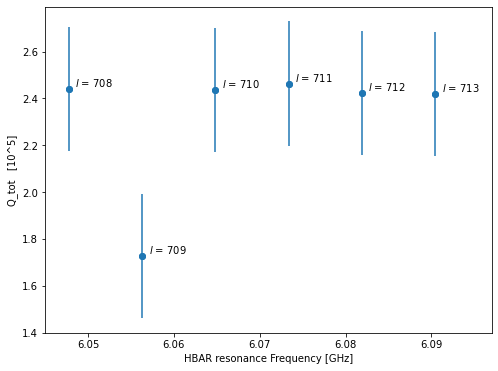

In [20]:
# #Make figure:
# plt.figure(figsize=(10,6))
# plt.scatter(f_HBAR/1e9,Ktot/1e3,label='\u03BA_tot')
# plt.ylabel('\u03BA_tot   [kHz]');  plt.xlabel('HBAR resonance Frequency [GHz]')
# plt.legend()


#Make figure:
plt.figure(figsize=(8,6))
plt.scatter(f_HBAR/1e9,Qtot/1e5,label='Q_tot')
plt.ylabel('Q_tot   [10^5]');  plt.xlabel('HBAR resonance Frequency [GHz]')
# plt.text(6.055, 2.4, 'Parabola $Y = x^2$', fontsize = 5)
for l in np.arange(len(l_mode)):
    plt.text(0.00075+f_HBAR[l]/1e9, 0.01+Qtot[l]/1e5, '$l$ = '+str(l_mode[l]), fontsize = 10)
# plt.ylim(2.1,2.7)
plt.xlim(6.045,6.097)
# plt.title('calculated FSR '+str(FSR_ave/1e6)+' MHz')
# plt.legend()

#calculate the standard deviation of Qtot:
## Maybe we should take multiple fits, have some average and take the std from that?
## This could also be done with different fits of same HBAR mode, but at different Stark drives?
### probably not the way to go?
Qtot_std = np.std(Qtot/1e5)

# adding error bars:
plt.errorbar(f_HBAR/1e9,Qtot/1e5, yerr=Qtot_std , fmt="o")
plt.show()

In [21]:
## MAYBE DO DOUBLE AXIS FOR Q AND KAPPA?

# fig, ax1 = plt.subplots()
# ax2 = ax1.twinx()
# # ax1.scatter(f_HBAR/1e9,Ktot/1e3, c='b',label='\u03BA_tot')
# # ax1.set_ylabel('\u03BA_tot   [kHz]', color = 'b')
# ax2.scatter(f_HBAR/1e9,Qtot/1e5, c='r',label='Q_tot')
# ax2.set_ylabel('Q_tot   [10^5]', color = 'r')
# ax1.set_xlabel('HBAR resonance Frequency [GHz]')
# plt.legend()

# # c = [1, 3, 2, 1,5,8]
# # plt.errorbar(f_HBAR/1e9,Ktot/1e3, yerr=c, fmt="o")
# # plt.show()

# decided to go for waterfall plot!
will try this first with qubit "fix2" Stark shift

In [22]:
# quick_plot_data(file_name="HBARtr_STARK_1_2023_01_17_23.11.48_Fix2_pw_spec_Reso", style='lcm') #reso
quick_plot_data(file_name="HBARtr_STARK_1_2023_01_17_23.11.48_Fix2_pw_spec", style='lcm') #spec

In [23]:
#looking at the data above, I'll probably need to retake the data anyways with more power steps and smaller freq. range
# take next time: 5.830 - 5.880 GHz, Stark power -22 to -6 dBm
#for now let's try to make the waterfall plot with what we've got!
#use columns: 4,7,8,10 ,12

['Frequency (Hz)', ' CH2_S21_S1re ()', ' CH2_S21_S1im ()', ' CH2_S21_S1dB (dB)', ' CH2_S21_S1Ph (rad)', ' Probe Power (dBm)', ' Drive Power (dBm)', ' VNA Port 1 RT Attn (dB)', ' VNA Port 2 RT Attn (dB)', ' Line inside fridge Attn (dB)', ' Number Miteqs', ' Stark freq [Hz]', ' Stark power [dBm]']
['Frequency (Hz)', ' CH2_S21_S1re ()', ' CH2_S21_S1im ()', ' CH2_S21_S1dB (dB)', ' CH2_S21_S1Ph (rad)', ' Probe Power (dBm)', ' Drive Power (dBm)', ' VNA Port 1 RT Attn (dB)', ' VNA Port 2 RT Attn (dB)', ' Line inside fridge Attn (dB)', ' Number Miteqs', ' Stark freq [Hz]', ' Stark power [dBm]']
['Frequency (Hz)', ' CH2_S21_S1re ()', ' CH2_S21_S1im ()', ' CH2_S21_S1dB (dB)', ' CH2_S21_S1Ph (rad)', ' Probe Power (dBm)', ' Drive Power (dBm)', ' VNA Port 1 RT Attn (dB)', ' VNA Port 2 RT Attn (dB)', ' Line inside fridge Attn (dB)', ' Number Miteqs', ' Stark freq [Hz]', ' Stark power [dBm]']
['Frequency (Hz)', ' CH2_S21_S1re ()', ' CH2_S21_S1im ()', ' CH2_S21_S1dB (dB)', ' CH2_S21_S1Ph (rad)', ' Pro

(5.845, 5.88)

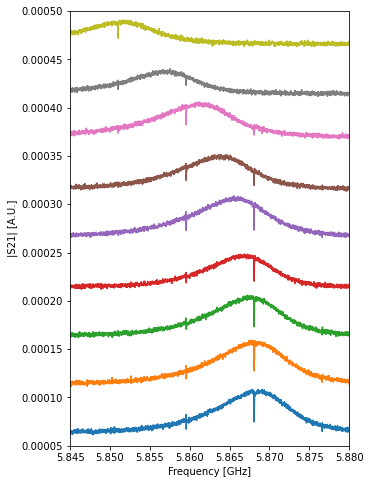

In [24]:
col_numbers = [4,5,6,7,8,9,10,11,12];
fall_shift = 0.5e-4

plt.figure(figsize=(5,8))
# plt.axvline(x=5.8596, color='b', ls='--',label='HBAR1')
# plt.axvline(x=5.86818, color='b', ls='--',label='HBAR2')
# plt.axvline(x=5.851, color='b', ls='--',label='HBAR3')
for i,nr in enumerate(col_numbers):
    ##load DATA
    Params=load_data(file_name = "HBARtr_STARK_1_2023_01_17_23.11.48_Fix2_pw_spec",col=nr)
    Freq,S21Real,S21Imag,S21dB,S21Ph,Probe_pow,Drive_pow,Port1_att,Port2_att,DU_att,RT_amps,f_stark,p_stark = Params

    #S21(dBm) -> S21
    S21 = 10**(S21dB/20)

    #plot data:
    #pnt_1 = 1500;     pnt_2 = 4200
    pnt_1 = 0;     pnt_2 = -1

    plt.plot(Freq[pnt_1:pnt_2]/1e9,S21[pnt_1:pnt_2]+i*fall_shift,'-',label='Data S21_'+str(nr))
    plt.ylabel('|S21| [A.U.]');  plt.xlabel('Frequency [GHz]')
# plt.legend()
plt.ylim([5e-5, (i+2)*fall_shift])
plt.xlim([5.845,5.88])

few comments from [Clinton in Mattermost](https://chat.quantumtinkerer.tudelft.nl/steelelab/pl/8a9b7ymejtn5zgun5nu1t4imio):

Few comments:
* Clinton:
    * ~~|S21| Isn't in arbitrary units; you can just say it in the caption offset for clarity. I would also maybe say |S21| * 10^3 or something, so there are not so many decimal points. Or plot it in dB.~~
    * ~~There are too many x and y tick labels. I would maybe use half as many and make the font larger.~~
    * ~~Dont put the black boxes around the figures~~
    * ~~Tick marks should point in (Personal preference)~~
    * ~~It might be worth using a colormap for (a) then you can use a color bar to show the stark power using the color of each of the traces~~
    * In (b), the fonts look different, and the tick marks are different. Make sure you use the same plotting code for both plots (a) and (b), (b) looks like a screengrab, but I would pull out the data and replot it.
    * I might also make the boarder and tick marks bolder in matplotlib.
* Gary:
    * ~~For the waterfall, I prefer just a series of colored lines like your first one~~
    * ~~But indeeed with four curves and in the aspect ratio of your most recent plot~~
    * ~~And I would add faint, think (0.5 pt), dashed grey vertical lines behind the data indicating the positions of the hbar resonances so you can see that they do exactly line up~~

['Frequency (Hz)', ' CH2_S21_S1re ()', ' CH2_S21_S1im ()', ' CH2_S21_S1dB (dB)', ' CH2_S21_S1Ph (rad)', ' Probe Power (dBm)', ' Drive Power (dBm)', ' VNA Port 1 RT Attn (dB)', ' VNA Port 2 RT Attn (dB)', ' Line inside fridge Attn (dB)', ' Number Miteqs', ' Stark freq [Hz]', ' Stark power [dBm]']
['Frequency (Hz)', ' CH2_S21_S1re ()', ' CH2_S21_S1im ()', ' CH2_S21_S1dB (dB)', ' CH2_S21_S1Ph (rad)', ' Probe Power (dBm)', ' Drive Power (dBm)', ' VNA Port 1 RT Attn (dB)', ' VNA Port 2 RT Attn (dB)', ' Line inside fridge Attn (dB)', ' Number Miteqs', ' Stark freq [Hz]', ' Stark power [dBm]']
['Frequency (Hz)', ' CH2_S21_S1re ()', ' CH2_S21_S1im ()', ' CH2_S21_S1dB (dB)', ' CH2_S21_S1Ph (rad)', ' Probe Power (dBm)', ' Drive Power (dBm)', ' VNA Port 1 RT Attn (dB)', ' VNA Port 2 RT Attn (dB)', ' Line inside fridge Attn (dB)', ' Number Miteqs', ' Stark freq [Hz]', ' Stark power [dBm]']
['Frequency (Hz)', ' CH2_S21_S1re ()', ' CH2_S21_S1im ()', ' CH2_S21_S1dB (dB)', ' CH2_S21_S1Ph (rad)', ' Pro

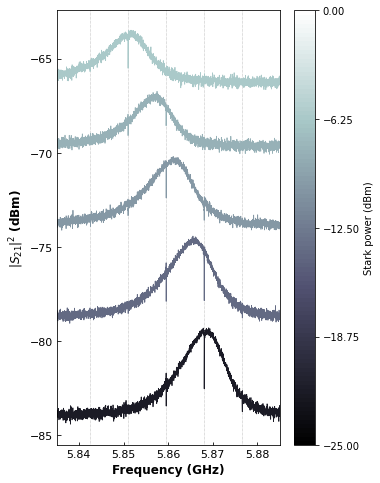

In [25]:
HBAR_freqs = [5.8425,5.851,5.8596,5.868,5.8765]
col_numbers = [4,8,10,11,12];      # col_numbers = [4,5,6,7,8,9,10,11,12]
pnt_1 = 0; pnt_2=-1

c1 = -25; c2 = 0
# colormap
colors = np.linspace(c1, c2, 100)
cmap = plt.get_cmap('bone', 100) 

#star figure + add HBAR vertical lines:
plt.figure(figsize=(5,8))
for i in HBAR_freqs:
    plt.axvline(x=i, color='grey', ls=':', lw=0.5)

for i,nr in enumerate(col_numbers):
    ##load DATA
    Params=load_data(file_name = "HBARtr_STARK_1_2023_01_17_23.11.48_Fix2_pw_spec",col=nr)
    Freq,S21Real,S21Imag,S21dB,S21Ph,Probe_pow,Drive_pow,Port1_att,Port2_att,DU_att,RT_amps,f_stark,p_stark = Params
    
    if i !=0:
        shift = set_max - min(S21dB)
        shift_add += shift
    elif i==0:
        shift_add = 0
        set_vmin = p_stark[0]
        
    #plot data:
    plt.plot(Freq/1e9,(S21dB+shift_add),
             '-', lw=0.8 ,label='Stark power '+str(p_stark[0]), 
             c=cmap((np.abs(np.asarray(colors) - p_stark[0])).argmin()))
    set_max = max(S21dB);     set_vmax = p_stark[0]
    
### Final plot settings ###
# plt.legend()
plt.ylabel('$|S_{21}|^{2}$ (dBm)', fontsize=12, weight='bold')
plt.xlabel('Frequency (GHz)', fontsize=12, weight='bold')
# plt.ylim([5e-5, (i+2)*fall_shift])
plt.xlim([5.835,5.885])
plt.yticks(fontsize=11, rotation=0)
plt.xticks([5.840, 5.850, 5.860, 5.870, 5.880], fontsize=11, rotation=0)
plt.tick_params(axis="y",direction="in"); plt.tick_params(axis="x",direction="in")

# creating ScalarMappable
set_vmin=c1; set_vmax = c2
sm = plt.cm.ScalarMappable(cmap=cmap, norm = mpl.colors.Normalize(vmin=set_vmin, vmax=set_vmax))
sm.set_array([])
plt.colorbar(sm, ticks=np.linspace(set_vmin, set_vmax, len(col_numbers)),label='Stark power (dBm)')

look into [cmap website](https://matplotlib.org/stable/tutorials/colors/colormaps.html)

Colors I/we dislike:
* 'copper' --> Clinton: looks like poop chart from the doctors office..
* 'cool' --> don't like the purple

Not sure:
* inferno, magma, hot, afmhot --> all become yellowish for higher stark power
* seismic, looks okay, but would like to use that one for colorplot of Stark sweep
* rainbow, jet, turbo
* 

Colors I/we like:
* 'bone'
* 

## Let's work on the colormap again

['Frequency (Hz)', ' CH2_S21_S1re ()', ' CH2_S21_S1im ()', ' CH2_S21_S1dB (dB)', ' CH2_S21_S1Ph (rad)', ' Probe Power (dBm)', ' Drive Power (dBm)', ' VNA Port 1 RT Attn (dB)', ' VNA Port 2 RT Attn (dB)', ' Line inside fridge Attn (dB)', ' Number Miteqs', ' Stark freq [Hz]', ' Stark power [dBm]']


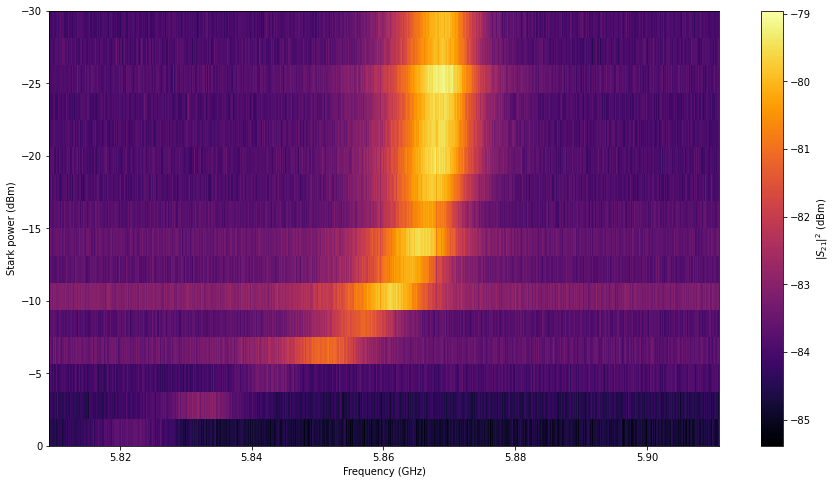

In [26]:
#load data
Freq,S21Real,S21Imag,S21dB,S21Ph,f_stark,p_stark=load_data_4colorplot(file_name = "HBARtr_STARK_1_2023_01_17_23.11.48_Fix2_pw_spec")
#create color plot:
plt.figure(figsize=(15,8))
plt.imshow(S21dB, cmap=plt.cm.inferno, interpolation='none', 
           extent=[Freq[0]/1e9,Freq[-1]/1e9,p_stark[-1],p_stark[0]], aspect="auto")
plt.xlabel('Frequency (GHz)');
plt.ylabel('Stark power (dBm)')
plt.colorbar(label='$|S_{21}|^2$ (dBm)')

# Now let's put them together as one figure (a & b)

['Frequency (Hz)', ' CH2_S21_S1re ()', ' CH2_S21_S1im ()', ' CH2_S21_S1dB (dB)', ' CH2_S21_S1Ph (rad)', ' Probe Power (dBm)', ' Drive Power (dBm)', ' VNA Port 1 RT Attn (dB)', ' VNA Port 2 RT Attn (dB)', ' Line inside fridge Attn (dB)', ' Number Miteqs', ' Stark freq [Hz]', ' Stark power [dBm]']


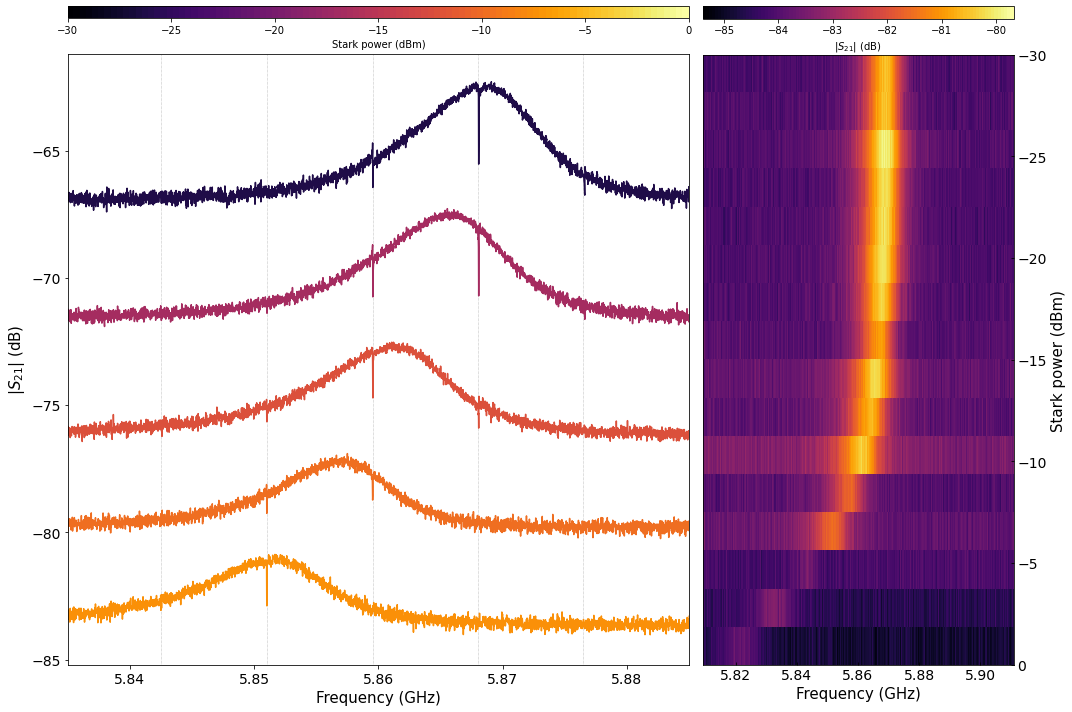

In [27]:
### OVERALL FIGURE SETTINGS & LOAD DATA:
##load Data:
Freq,S21Real,S21Imag,S21dB,S21Ph,f_stark,p_stark=load_data_4colorplot(file_name="HBARtr_STARK_1_2023_01_17_23.11.48_Fix2_pw_spec")

##settings:
# fig = plt.figure(figsize=(15, 10));   spec = fig.add_gridspec(1, 3)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 10), gridspec_kw={'width_ratios': [10, 5]})
color_name = 'inferno';         color_name2 = color_name

fntsize = 14;            fntsize_text = 15


##chosen HBARs and Stark powers
HBAR_freqs = [5.8425,5.851,5.8596,5.868,5.8765]
col_numbers = [12,11,10,8,4]            #[4,8,10,11,12];      # col_numbers = [4,5,6,7,8,9,10,11,12]
# ----------------------------------------------------- figure A --------------------------------------------------
shifter = [5,4,3,5,5]

c1 = -25; c2 = 0
# colormap
colors = np.linspace(c1, c2, 100);        cmap = plt.get_cmap(color_name, 100) 

#star figure + add HBAR vertical lines:
for i in HBAR_freqs:
    ax1.axvline(x=i, color='grey', ls=':', lw=0.5)

for i,nr in enumerate(col_numbers):
    ##load DATA
    if i !=0:
        shift = set_min - max(S21dB[col_numbers[i-1]])
        shift_add += shifter[i]
    elif i==0:
        shift_add = 0
        
    #plot data:
    ax1.plot(Freq/1e9,(S21dB[nr]+shift_add),
             '-', lw=1.5 ,label='Stark power '+str(p_stark[i]), 
             c=cmap((np.abs(np.asarray(colors) - p_stark[nr])).argmin()))
    set_min = min(S21dB[col_numbers[i]])
    
### Final plot settings ###
ax1.set_ylabel('$|S_{21}|$ (dB)', fontsize=fntsize_text)#, weight='bold')
ax1.set_xlabel('Frequency (GHz)', fontsize=fntsize_text)#, weight='bold')
ax1.set_xlim([5.835,5.885])
plt.tick_params(axis="y",direction="in"); plt.tick_params(axis="x",direction="in")

# creating ScalarMappable
set_vmin=c1; set_vmax = c2
sm = plt.cm.ScalarMappable(cmap=cmap, norm = mpl.colors.Normalize(vmin=p_stark[-1], vmax=p_stark[0]))
sm.set_array([])
cax = make_axes_locatable(ax1).new_vertical(size = '1.9%', pad = 0.5)
fig.add_axes(cax)
fig.colorbar(sm, cax=cax, orientation='horizontal',  aspect=45, pad=0.08, label='Stark power (dBm)')
ax1.xaxis.set_tick_params(labelsize=fntsize); ax1.yaxis.set_tick_params(labelsize=fntsize)

# ----------------------------------------------------- figure B --------------------------------------------------
#create color plot:
ax2.imshow(S21dB, cmap=color_name2, interpolation='none', 
           extent=[Freq[0]/1e9,Freq[-1]/1e9,p_stark[-1],p_stark[0]], aspect="auto")
ax2.set_xlabel('Frequency (GHz)', fontsize=fntsize_text)#, weight='bold');  
ax2.set_ylabel('Stark power (dBm)', fontsize=fntsize_text)#, weight='bold')
ax2.yaxis.tick_right(); ax2.yaxis.set_label_position("right"); 

# colormap
colors = np.linspace(min(S21dB[-1]), max(S21dB[0]), 100)
cmap = plt.get_cmap(color_name2, 100) 
sm = plt.cm.ScalarMappable(cmap=cmap, norm = mpl.colors.Normalize(vmin=min(S21dB[-1]), vmax=max(S21dB[0])))
# sm.set_array([])
cax = make_axes_locatable(ax2).new_vertical(size = '2%', pad = 0.5)
fig.add_axes(cax)
fig.colorbar(sm,cax=cax, orientation='horizontal', aspect=20, pad=0.08, label='$|S_{21}|$ (dB)')
ax2.xaxis.set_tick_params(labelsize=fntsize); ax2.yaxis.set_tick_params(labelsize=fntsize)

fig.tight_layout()
# plt.show()

# plt.savefig('Stark_plot.pdf') 

# Now (20March, 2023) we have new data:
So let's do the same as in the above!

In [28]:
# quick_plot_data(file_name="Fine_STARK_1_2023_03_15_20.57.21_Fix2_spec_Reso", style='lcm') #reso
quick_plot_data(file_name="Fine_STARK_1_2023_03_15_20.57.21_Fix2_spec", style='lcm') #spec
# 1, 31, 43, 56, 66, 70

['Frequency (Hz)', ' CH2_S21_S1re ()', ' CH2_S21_S1im ()', ' CH2_S21_S1dB (dB)', ' CH2_S21_S1Ph (rad)', ' Probe Power (dBm)', ' Drive Power (dBm)', ' VNA Port 1 RT Attn (dB)', ' VNA Port 2 RT Attn (dB)', ' Line inside fridge Attn (dB)', ' Number Miteqs', ' Stark freq [Hz]', ' Stark power [dBm]']


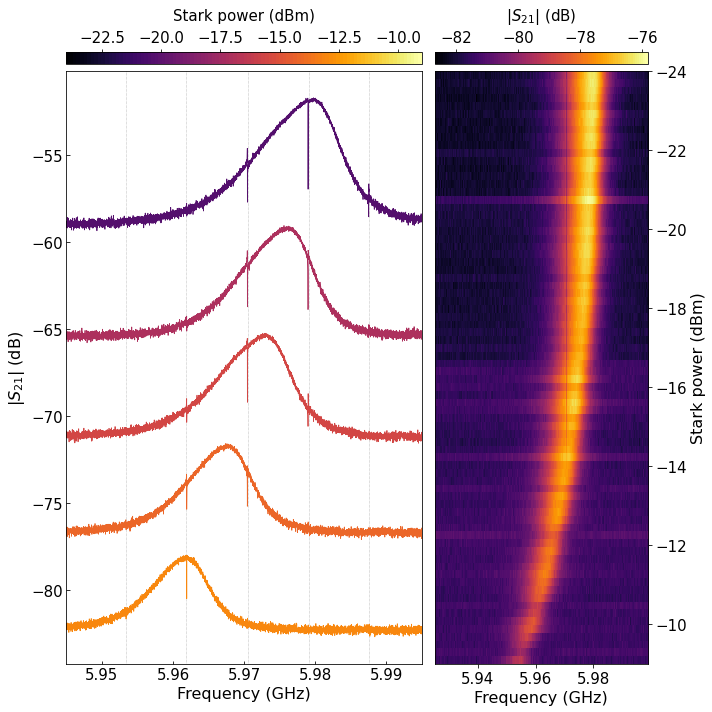

In [48]:
### OVERALL FIGURE SETTINGS & LOAD DATA:
##load Data:
Freq,S21Real,S21Imag,S21dB,S21Ph,f_stark,p_stark=load_data_4colorplot(file_name="Fine_STARK_1_2023_03_15_20.57.21_Fix2_spec")

##settings:
# fig = plt.figure(figsize=(15, 10));   spec = fig.add_gridspec(1, 3)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 10), gridspec_kw={'width_ratios': [10, 6]})
color_name = 'inferno';         color_name2 = color_name

fntsize = 15;            fntsize_text = 16

##chosen HBARs and Stark powers
HBAR_freqs = [5.98756, 5.97907, 5.97051, 5.96188, 5.95339]
col_numbers = [66, 56, 43, 31, 1]            #[75,70]
# ----------------------------------------------------- figure A --------------------------------------------------
shifter = [5.5,5.5,5.5,6.5,6.5]

c1 = -30; c2 = -4
# colormap
colors = np.linspace(c1, c2, 100);        cmap = plt.get_cmap(color_name, 100) 

#star figure + add HBAR vertical lines:
for i in HBAR_freqs:
    ax1.axvline(x=i, color='grey', ls=':', lw=0.5)

for i,nr in enumerate(col_numbers):
    ##load DATA
    if i !=0:
        shift = set_min - max(S21dB[col_numbers[i-1]])
        shift_add += shifter[i]
    elif i==0:
        shift_add = 0
        
    #plot data:
    ax1.plot(Freq/1e9,(S21dB[nr]+shift_add),
             '-', lw=0.8 ,label='Stark power '+str(p_stark[i]), 
             c=cmap((np.abs(np.asarray(colors) - p_stark[nr])).argmin()))
    set_min = min(S21dB[col_numbers[i]])
    
### Final plot settings ###
ax1.set_ylabel('$|S_{21}|$ (dB)', fontsize=fntsize_text)#, weight='bold')
ax1.set_xlabel('Frequency (GHz)', fontsize=fntsize_text)#, weight='bold')
ax1.set_xlim([5.945,5.995])
ax1.tick_params(axis="y",direction="in"); ax1.tick_params(axis="x",direction="in")

# creating ScalarMappable
set_vmin=c1; set_vmax = c2
sm = plt.cm.ScalarMappable(cmap=cmap, norm = mpl.colors.Normalize(vmin=p_stark[0], vmax=p_stark[-1]))
sm.set_array([])
cax = make_axes_locatable(ax1).new_vertical(size = '1.9%', pad = 0.1)
fig.add_axes(cax).tick_params(direction='out',labelsize=fntsize)
fig.colorbar(sm,cax=cax, orientation='horizontal', aspect=45, pad=0.08).set_label(label='Stark power (dBm)', 
                                                                         size=fntsize,labelpad=10)#, weight='bold')
cax.xaxis.set_label_position("top");   cax.xaxis.set_ticks_position("top")
ax1.xaxis.set_tick_params(labelsize=fntsize); ax1.yaxis.set_tick_params(labelsize=fntsize)

# ----------------------------------------------------- figure B --------------------------------------------------
#create color plot:
ax2.imshow(S21dB, cmap=color_name2, interpolation='none', 
           extent=[Freq[0]/1e9,Freq[-1]/1e9,p_stark[-1],p_stark[0]], aspect="auto")
ax2.set_xlabel('Frequency (GHz)', fontsize=fntsize_text)#, weight='bold');  
ax2.set_ylabel('Stark power (dBm)', fontsize=fntsize_text)#, weight='bold')
ax2.yaxis.tick_right(); ax2.yaxis.set_label_position("right"); 
ax2.set_xlim([5.925,5.999])

# colormap
colors = np.linspace(min(S21dB[-1]), max(S21dB[0]), 100)
cmap = plt.get_cmap(color_name2, 100) 
sm = plt.cm.ScalarMappable(cmap=cmap, norm = mpl.colors.Normalize(vmin=min(S21dB[-1]), vmax=max(S21dB[0])))
cax = make_axes_locatable(ax2).new_vertical(size='2%', pad = 0.1)

fig.add_axes(cax).tick_params(direction='out',labelsize=fntsize)
fig.colorbar(sm,cax=cax, orientation='horizontal', aspect=20, pad=0.08).set_label(label='$|S_{21}|$ (dB)', 
                                                                    size=fntsize,labelpad=10)#, weight='bold')
cax.xaxis.set_label_position("top");   cax.xaxis.set_ticks_position("top")
ax2.xaxis.set_tick_params(labelsize=fntsize); ax2.yaxis.set_tick_params(labelsize=fntsize)

fig.tight_layout()
# plt.savefig('Stark_plot.pdf') 
plt.show()

# changes for plot above (19 April, 2023):
* Had a [meeting](https://tudelft.zoom.us/rec/share/_UjHsNhXP5M5NxyLQ2yyynpF3YVTRO_fhIehC8wgHW8HA755MddM4B2d0dqvLWDW.tA1BloMW9cvEYpgS)
    * Passcode: xJp96=0b
* changes for the figure above:
    - add arrow FSR
    - remove colorplot
    - remove colorbar above left panel
    - in caption write powers off (generator powers)
* so below let's make the newest version

In [186]:
### OVERALL FIGURE SETTINGS & LOAD DATA:
##load Data:
Freq,S21Real,S21Imag,S21dB,S21Ph,f_stark,p_stark=load_data_4colorplot(file_name="Fine_STARK_1_2023_03_15_20.57.21_Fix2_spec")

##settings:
fig = plt.figure(figsize=(15, 10))
fig, ax1 = plt.subplots(1, 1, figsize=(8, 10))
color_name = 'inferno';         color_name2 = color_name

fntsize = 15;            fntsize_text = 16

##chosen HBARs and Stark powers
HBAR_freqs = [5.98756, 5.97907, 5.97051, 5.96188, 5.95339]
col_numbers = [65,55,45,30,0]       # Stark powers: -11.0,-13.0,-15.0,-18.0,-24.0     ##old linecuts[66, 56, 43, 31, 1]
# ----------------------------------------------------- figure  --------------------------------------------------
shifter = [5.5,5.5,5.5,6.5,6.5]

c1 = -30; c2 = -4
# colormap
colors = np.linspace(c1, c2, 100);        cmap = plt.get_cmap(color_name, 100) 

#star figure + add HBAR vertical lines:
for j,i in enumerate(HBAR_freqs):
    ax1.axvline(x=i, ymin=0.00, ymax=1, color='grey', ls=':', lw=1.1)

for i,nr in enumerate(col_numbers):
    ##load DATA
    if i !=0:
        shift = set_min - max(S21dB[col_numbers[i-1]])
        shift_add += shifter[i]
    elif i==0:
        shift_add = 0
        
    #plot data:
    ax1.plot(Freq/1e9,(S21dB[nr]+shift_add),
             '-', lw=0.8 ,label='Stark power '+str(p_stark[i]), 
             c=cmap((np.abs(np.asarray(colors) - p_stark[nr])).argmin()))
    set_min = min(S21dB[col_numbers[i]])
    
### Final plot settings ###
ax1.set_ylabel('$|S_{21}|$ (dB)', fontsize=fntsize_text)#, weight='bold')
ax1.set_xlabel('Frequency (GHz)', fontsize=fntsize_text)#, weight='bold')
ax1.set_xlim([5.945,5.995]); #ax1.set_ylim([-83,-50])
ax1.tick_params(axis="y",direction="in"); ax1.tick_params(axis="x",direction="in")

# creating ScalarMappable
set_vmin=c1; set_vmax = c2
sm = plt.cm.ScalarMappable(cmap=cmap, norm = mpl.colors.Normalize(vmin=p_stark[0], vmax=p_stark[-1]))
sm.set_array([])
cax = make_axes_locatable(ax1).new_vertical(size = '1.9%', pad = 0.1)
ax1.xaxis.set_tick_params(labelsize=fntsize); ax1.yaxis.set_tick_params(labelsize=fntsize)

#add an arrow + text:
plt.arrow(5.95339, -56, 0.0085, 0, head_width=0.5, head_length=0.001, linewidth=2, color='k', length_includes_head=True)
plt.arrow(5.96188, -56, -0.0085, 0, head_width=0.5, head_length=0.001, linewidth=2, color='k', length_includes_head=True)
plt.text(x=5.952, y=-55, s=r'FSR$\approx$8.53 MHz', fontsize=fntsize, color='black')

fig.tight_layout()
# plt.savefig('Stark_plot_V2.pdf') 
plt.show()

<Figure size 1080x720 with 0 Axes>

[APL paper regulations](https://aip.scitation.org/apl/authors/manuscript#:~:text=For%20JMP%20(one%2Dcolumn%20journal,high%3B%201%2F8%20in.)
For JMP (one-column journal)
* The maximum published width of figures is 6.69 inches (17 cm). 
* The maximum depth of figures should be 8 ¼ in. (21.1 cm). 
* Legends or labels within figures should be a minimum of 8-point type size (2.8 mm high; 1/8 in. high). 
* A minimum of 0.5 point width for lines.

For all other journals: 
* The maximum published width for a one-column figure is 3.37 inches (8.5 cm). 
* The maximum width for a two-column figure is 6.69 inches (17 cm). 
* The maximum depth of figures should be 8 ¼ in. (21.1 cm). 
* Legends or labels within figures should be a minimum of 8-point type size (2.8 mm high; 1/8 in. high). 
* A minimum of 0.5 point width for lines.

Figures should be saved with minimum of 600 dpi!

# Need to remake the above figure!
* Oct. 11, 2023 working on AIT paper again, now with mean field theory
* most measurements and fits (including the one in the lasing paper) were done on a flux tunable (SQUID) qubit
* above we made the figure with a fixed frequency qubit...
* Thus, We need to redo this....

In [10]:
### IMPORTS ###
import glob, os, datacube, xarray, bokeh, time, math, scipy
import stlabutils;   # import stlab
import numpy as np

import matplotlib.pyplot  as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import LogNorm
from matplotlib.pyplot import cm
import matplotlib.image as mpimg
import matplotlib as mpl

File_path = "/home/jovyan/steelelab/measurement_data/Triton/Jasper/HBAR_transmon_flipchip/"

def load_data_4colorplot(file_name = "HBARtr_STARK_1_2023_01_21_23.46.25_Fix3_pw_spec"):
    file_pre = File_path+file_name+'/'+file_name+'.dat';    file = stlabutils.readdata.readdat(file_pre,delim=',')
    
    #Extract once:
    Freq=file[0]['Frequency (Hz)'].values;    f_stark=file[0][' Stark freq [Hz]'].values[0];
    #
    S21Real=[]; S21Imag=[]; S21dB=[]; S21Ph=[]; p_stark=[];
    
    for i in np.arange(len(file)):
        #EXTRACT DATA:
        #VNA data:
        S21Real.append(file[i][' CH2_S21_S1re ()'].values)
        S21Imag.append(file[i][' CH2_S21_S1im ()'].values)     
        # S21 = S21Real + 1j*S21Imag
        S21dB.append(file[i][' CH2_S21_S1dB (dB)'].values) 
        S21Ph.append(file[i][' CH2_S21_S1Ph (rad)'].values)  

        #Stark settings:
        p_stark.append(file[i][' Stark power [dBm]'].values[0])
    
    return Freq,S21Real,S21Imag,S21dB,S21Ph,f_stark,p_stark

### RC params ####
# plt.rc('font', size=8)          # controls default text sizes
# plt.rc('axes', labelsize=8)    # axis labels
# plt.rc('xtick', labelsize=6)    # fontsize of the tick labels
# plt.rc('ytick', labelsize=6)    # fontsize of the tick labels
# plt.rc('legend', fontsize=6)    # legend fontsize
### RC params ####
plt.rc('font', size=16)          # controls default text sizes
plt.rc('axes', labelsize=10)    # axis labels
plt.rc('xtick', labelsize=12)    # fontsize of the tick labels
plt.rc('ytick', labelsize=12)    # fontsize of the tick labels
plt.rc('legend', fontsize=12)    # legend fontsize

# rc params linecuts
plt.rcParams['lines.linewidth'] = 1
plt.rcParams['lines.linestyle'] = ':'
plt.rcParams['lines.markersize'] = 1

# rc params colorplots:


# rc params general plotting:
plt.rcParams['xtick.direction'] = "in"
plt.rcParams['ytick.direction'] = "in"
plt.rcParams['image.interpolation'] = 'none'
plt.rcParams['figure.figsize'] = (8,8)
plt.rcParams['figure.dpi'] = 250
plt.rcParams['savefig.dpi'] = 500
plt.rcParams['savefig.format'] = 'pdf'#'png'#'jpg'

In [54]:
new_stark_POWS = [-22.,-21.5, -21.,  -20.5, -20.,  -19.5, -19.,  -18.5, -18., -17.5, -17., -16.5,
                  -16., -15.5, -15.,  -14.5, -14.,  -13.5, -13.,  -12.5, -12., -11.5 -11.,-10.5,
                  -10., -9.5, -9., -8.5, -8., -7.5, -7.,-6.5, -6., -5.5, -5., -4.5, -4., -3.5, -3.,-2.5,-2. ]

for iii,kkk in enumerate([28,25,20,13,0]):
    print(new_stark_POWS[kkk])


-7.5
-9.0
-12.0
-15.5
-22.0


['Frequency (Hz)', ' CH2_S21_S1re ()', ' CH2_S21_S1im ()', ' CH2_S21_S1dB (dB)', ' CH2_S21_S1Ph (rad)', ' Probe Power (dBm)', ' Drive Power (dBm)', ' VNA Port 1 RT Attn (dB)', ' VNA Port 2 RT Attn (dB)', ' Line inside fridge Attn (dB)', ' Number Miteqs', ' Stark freq [Hz]', ' Stark power [dBm]']


<Figure size 3750x2500 with 0 Axes>

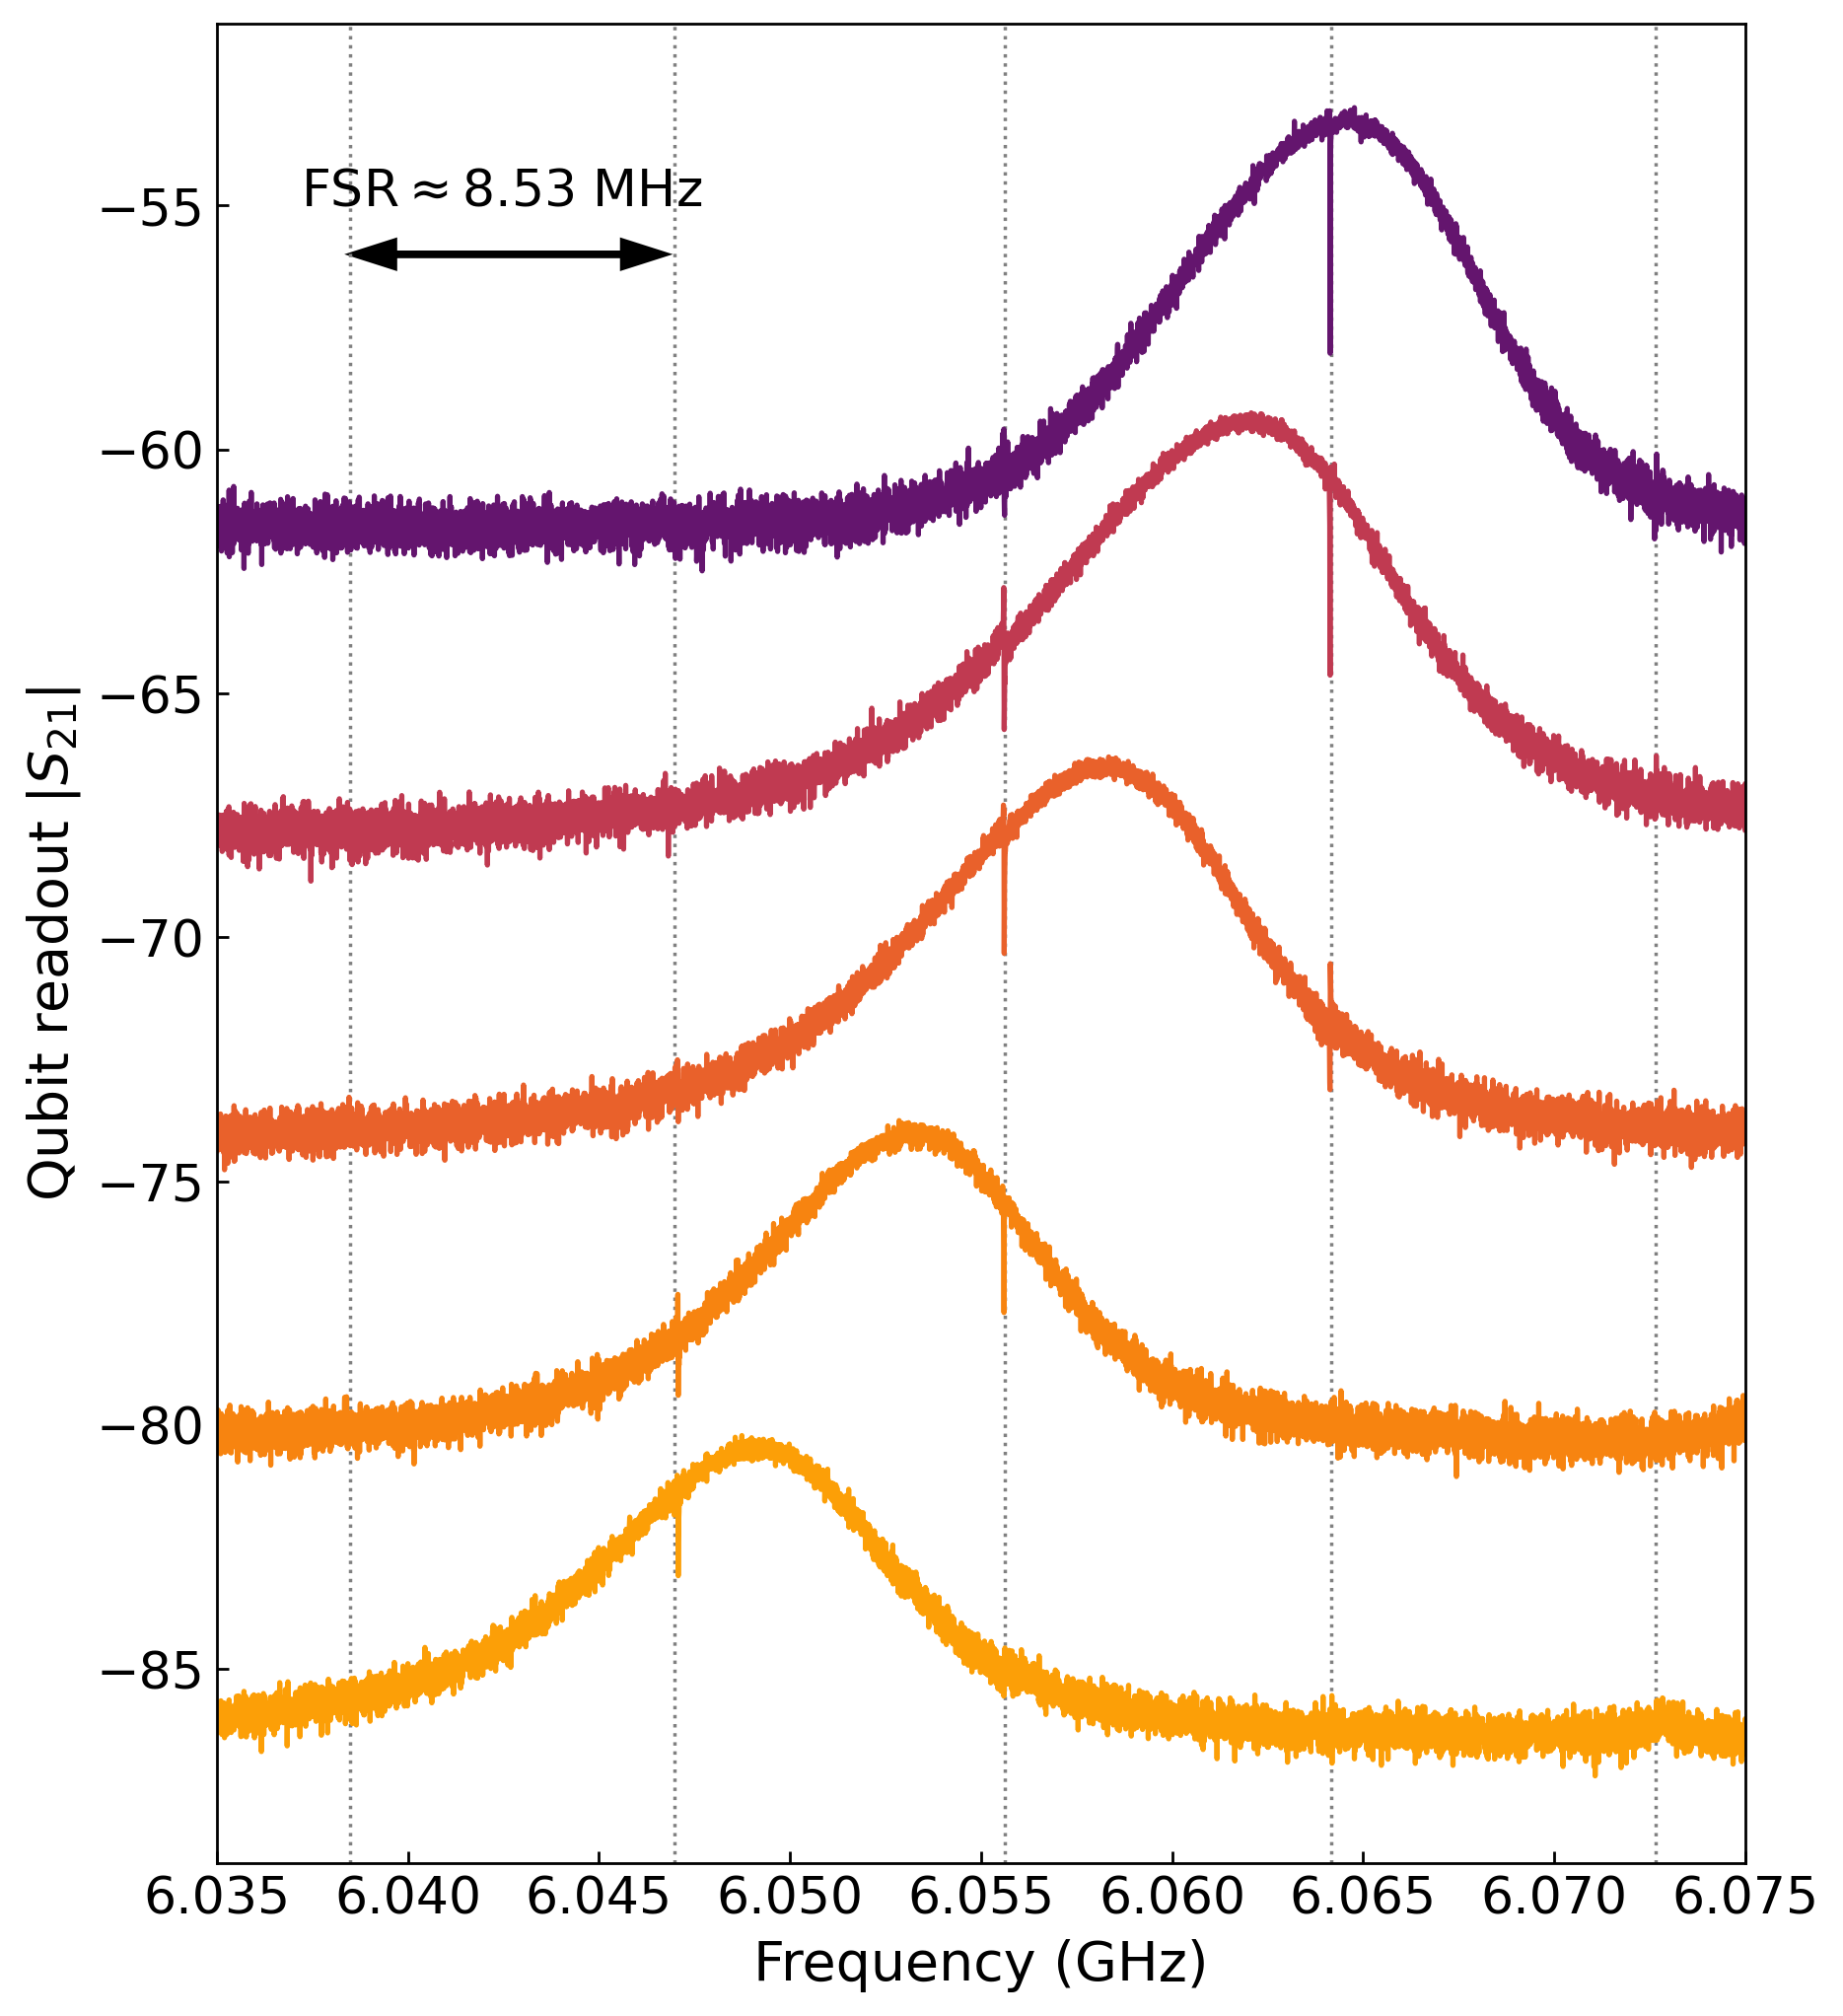

In [60]:
### OVERALL FIGURE SETTINGS & LOAD DATA:
##load Data:
Freq,S21Real,S21Imag,S21dB,S21Ph,f_stark,p_stark=load_data_4colorplot(file_name="STARK_Qdrive_Pswp1_2023_08_22_14.46.01_Flux1_pw_spec")

##settings:
fig = plt.figure(figsize=(15, 10))
fig, ax1 = plt.subplots(1, 1, figsize=(8, 10))
color_name = 'inferno';         color_name2 = color_name

fntsize = 15;            fntsize_text = 16

##chosen HBARs and Stark powers
HBAR_freqs = [5.98756, 5.97907, 5.97051, 5.96188, 5.95339]
col_numbers = [28,25,20,13,0]       # Stark powers: -22.0,-15.5,-12.0,-9.0,-7.5
# ----------------------------------------------------- figure  --------------------------------------------------
shifter = [6.5,6.5,6.5,6.5,6.5]

c1 = -30; c2 = -2
# colormap
colors = np.linspace(c1, c2, 100);        cmap = plt.get_cmap(color_name, 100) 

#star figure + add HBAR vertical lines:
for j,i in enumerate(HBAR_freqs):
    ax1.axvline(x=i+0.0851, ymin=0.00, ymax=1, color='grey', ls=':', lw=1.0)

for i,nr in enumerate(col_numbers):
    ##load DATA
    if i !=0:
        shift = set_min - max(S21dB[col_numbers[i-1]])
        shift_add += shifter[i]
    elif i==0:
        shift_add = 0
        
    #plot data:
    ax1.plot(Freq/1e9,(S21dB[nr]+shift_add),
             '-', lw=1.5 ,label='Stark power '+str(p_stark[i]), 
             c=cmap((np.abs(np.asarray(colors) - p_stark[nr])).argmin()))
    set_min = min(S21dB[col_numbers[i]])
    
### Final plot settings ###
ax1.set_ylabel(r'Qubit readout $|S_{21}|$', fontsize=fntsize_text)#, weight='bold')
ax1.set_xlabel('Frequency (GHz)', fontsize=fntsize_text)#, weight='bold')
ax1.set_xlim([6.035,6.075]); #ax1.set_ylim([-83,-50])
ax1.tick_params(axis="y",direction="in"); ax1.tick_params(axis="x",direction="in")

# creating ScalarMappable
set_vmin=c1; set_vmax = c2
sm = plt.cm.ScalarMappable(cmap=cmap, norm = mpl.colors.Normalize(vmin=p_stark[0], vmax=p_stark[-1]))
sm.set_array([])
cax = make_axes_locatable(ax1).new_vertical(size = '1.9%', pad = 0.1)
ax1.xaxis.set_tick_params(labelsize=fntsize); ax1.yaxis.set_tick_params(labelsize=fntsize)

#add an arrow + text:
plt.arrow(5.95339+0.086, -56, 0.00725, 0, head_width=0.5, head_length=0.001, linewidth=2, color='k', length_includes_head=True)
plt.arrow(5.96188+0.084, -56, -0.00725, 0, head_width=0.5, head_length=0.001, linewidth=2, color='k', length_includes_head=True)
plt.text(x=5.952+0.0852, y=-55, s=r'FSR$\approx$8.53 MHz', fontsize=fntsize, color='black')


## Save data:
# plt.savefig('AIT_MF_fig2',bbox_inches = 'tight')

plt.show()

In [57]:
f_stark

6096050000.0